# Simulation of a GBS experiment

In this notebook, we calculate the vibronic spectrum of $V_3$ using a sampling method, simulating a Gaussian Boson Sampling experiment. We will use `StrawberryFields` for the simulation. "Strawberry Fields" is a code created by Xanadu and is the driver behind GBS. This can be installed using **pip**, but see install instructions in the <a href="https://github.com/CDL-Quantum/CohortProject_2020/blob/master/Project_3_Franck_Condon_Factors/Project3_LandingPage.pdf"> Project 3 Landing Page</a>.

First, let us import necessary packages

In [3]:
from sys import argv
from strawberryfields.apps import vibronic, data, sample, plot
import numpy as np
from common.utils import get_state, plot_spectrum, plot_spectrum_from_samples
# from plotly import offline
# offline.init_notebook_mode(connected = True)

The `FC.cxx` programm we looked at in the previous notebook, does some intermediate calculations which carry necessary information for the input to GBS. We modified the `FC.cxx` a bit (see the code after the comment line "start writing the file for GBS") to output all the required information into a text file Variables. After compiling and executing this code, we have the necessary file to feed to GBS simulation. 

Let us first declare some variables

In [4]:
# inputfile = open(argv[1], "r")
inputfile = open("common/FC/output/V3.duschinsky.out", "r")

N=int(inputfile.readline())     #Number of Atoms
nmodes=3*N-6                    #Number of Modes

w=np.zeros(nmodes,float)        #vib. frequencies of ground electronic state
wp=np.zeros(nmodes,float)       #vib. frequencies of excited electronic state
Ud=np.zeros((nmodes,nmodes),float)   #Duschinsky Matrix
delta=np.zeros(nmodes,float)    #Displacement Vector

T = 500  # temperature

Read in Parameters.

The code below assumes, that the input file has the following structure
```
1 line: number of atoms
1 line: space-separated list of normal frequencies of the ground state
1 line: space-separated list of normal frequencies of the excited state
nmodes lines: each line space-separated numbers representing a row in Duschinsky matrix
1 line: space-separated list of displacements
```

In [5]:
w = np.array([float(x) for x in inputfile.readline().split()])
wp = np.array([float(x) for x in inputfile.readline().split()])
for i in range(nmodes):
    Ud[i, :] = np.array([float(x) for x in inputfile.readline().split()])
delta = np.array([float(x) for x in inputfile.readline().split()])

Use "Strawberry Fields" to calculate GBS Parameters based on the frequencies, Duschinsky matrix, and temperature that was provided as input.

In [6]:
t, U1, r, U2, alpha = vibronic.gbs_params(w, wp, Ud, delta, T)

Generate Samples and Calculate Energies of Samples.

Note: The number of samples may be changed if the spectrum is not converged.

In [7]:
nr_samples = 20
s = sample.vibronic(t, U1, r, U2, alpha, nr_samples)
e = vibronic.energies(s, w, wp)

To plot the spectrum we use the function `plot_spectrum_from_samples` we have implemented in `utils.py`, which is using matplotlib to do the plotting.

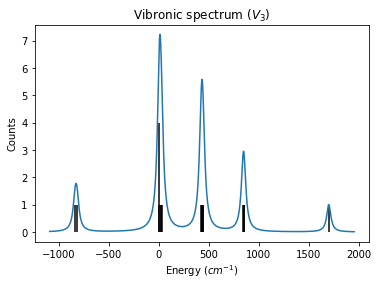

In [11]:
# spectrum = plot.spectrum(e, xmin=-1000, xmax=2000)
# offline.iplot(spectrum)

plot_desc = {'title': "Vibronic spectrum ($V_3$)", 'xlabel': "Energy ($cm^{-1}$)", 'ylabel': "Counts"}
plot_spectrum_from_samples(e, plot_desc, gamma=50.0)

### Challenge 1

Instead of sampling a photonic devie and approximating the probabilities of output energies based on the sampling results, we can compute the exact probabilities using loop hafnians. Ideally, we would calculate the exact probabilities of all possible output patterns and construct the spectrum based on this exact probability distribution. For wach output pattern we will need to calculate a loop hafnian. With incresing photon numbers this calculations become intractable, since 1. The loop hafnian is exponentially hard to calculate classicaly, 2. The number of output patters becomes exponentially many. Instead of calculating the entire probability distribution exactly, we will just calculate the exact probabilities for patters which are supposed to have high probability, which we got in the previous step, while sampling the GBS device.

In [8]:
s_unique = list(set([tuple(item) for item in s]))
s_unique = [list(x) for x in s_unique]

e_unique = vibronic.energies(s_unique, w, wp)

state = get_state(t, U1, r, U2, alpha)
probs = [state.fock_prob(pattern, cutoff=20) for pattern in s_unique]

And we plot the result

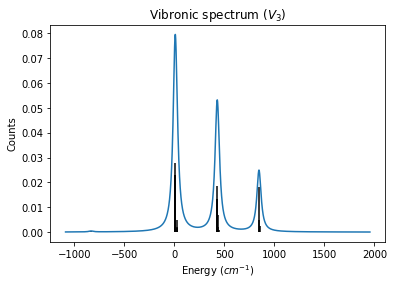

In [12]:
plot_spectrum(np.vstack([e_unique, probs]), plot_desc, gamma=50.0)